# Data Ingest

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

IMG_SIZE = (224,224)
CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
BATCH_SIZE = 32
TF_RANDOM_SEED = 42

def make_data_gen(dir_location):
#     data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    return data_gen.flow_from_directory(dir_location,
                                              target_size=IMG_SIZE,
                                              classes=CLASS_LABELS,
                                              class_mode='sparse',
                                              seed=TF_RANDOM_SEED)
train_data = make_data_gen(TRAIN_DIR)

Found 10000 images belonging to 5 classes.


In [3]:
# TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

# IMG_SIZE = (224,224)
# CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
# BATCH_SIZE = 32
# TF_RANDOM_SEED = 42

# def make_data_gen(dir_location):
# #     data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
# #     return data_gen.flow_from_directory(dir_location,
# #                                               target_size=IMG_SIZE,
# #                                               classes=CLASS_LABELS,
# #                                               class_mode='sparse',
# #                                               seed=TF_RANDOM_SEED)
#     return tf.keras.utils.image_dataset_from_directory(dir_location,
#                                                       seed=TF_RANDOM_SEED,
#                                                       image_size=IMG_SIZE,
#                                                       batch_size=BATCH_SIZE)
# train_data = make_data_gen(TRAIN_DIR)
# # make_data_gen(TRAIN_DIR)
# train_data.take(0).take(0)

In [4]:
# def show_batch_images(batch_dataset):
#     plt.subplots(4, 6)
    
#     for entries in batch_dataset.take(1):
# #         for image, label in entries:
# #             print(image.shape, label)
#         images, labels = entries
#         for image in images:
#             plt.imshow(image)
# #         print(entries[0].shape)
    
#     plt.axis('off')

# show_batch_images(train_data)

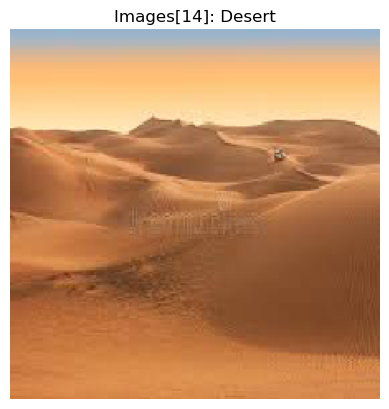

In [5]:
def show_random_image(dir_iter):
    batch_index = 0
    img_index = np.random.randint(32)
    label = CLASS_LABELS[int(dir_iter[batch_index][1][img_index])]

    plt.imshow(dir_iter[batch_index][0][img_index]/255.0)
    plt.title(f"Images[{img_index}]: {label}")
    plt.axis("off")
    plt.show()

show_random_image(train_data)

Found 1500 images belonging to 5 classes.


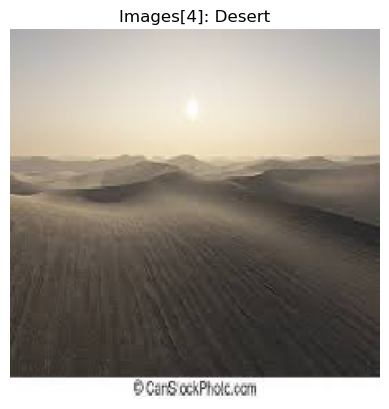

In [6]:
VALID_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data'

valid_data = make_data_gen(VALID_DIR)
show_random_image(valid_data)

Found 500 images belonging to 5 classes.


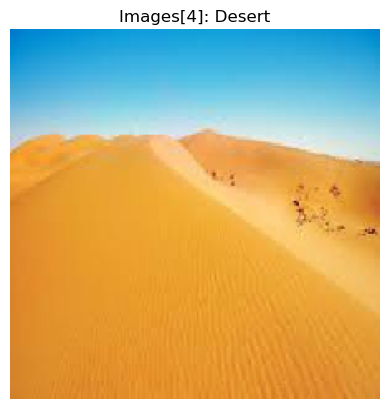

In [7]:
TEST_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

test_data = make_data_gen(TEST_DIR)
show_random_image(test_data)

# Model 1A - Efficient Nets with Feature Extraction

In [8]:
EPOCHS = 5

tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))

basenet_model = tf.keras.applications.EfficientNetB0(include_top=False)
basenet_model.trainable = False
basenet_model = basenet_model(inputs)

outputs = tf.keras.layers.GlobalAveragePooling2D()(basenet_model)
outputs = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(outputs)

effnet_model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [9]:
def train_model(model, callbacks=[]):
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model.fit(train_data, 
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data, 
                     validation_steps=int(0.25 * len(valid_data)),
                     callbacks=callbacks)

In [10]:
effnet_history = train_model(effnet_model)

Epoch 1/5
313/313 [==============================] - 59s 157ms/step - loss: 0.5462 - accuracy: 0.8228 - val_loss: 0.4914 - val_accuracy: 0.8182
Epoch 2/5
313/313 [==============================] - 29s 91ms/step - loss: 0.3555 - accuracy: 0.8844 - val_loss: 0.5584 - val_accuracy: 0.8125
Epoch 3/5
313/313 [==============================] - 30s 95ms/step - loss: 0.3203 - accuracy: 0.8910 - val_loss: 0.4674 - val_accuracy: 0.8295
Epoch 4/5
313/313 [==============================] - 28s 91ms/step - loss: 0.2943 - accuracy: 0.9017 - val_loss: 0.4757 - val_accuracy: 0.8153
Epoch 5/5
313/313 [==============================] - 29s 93ms/step - loss: 0.2801 - accuracy: 0.9050 - val_loss: 0.4765 - val_accuracy: 0.8381


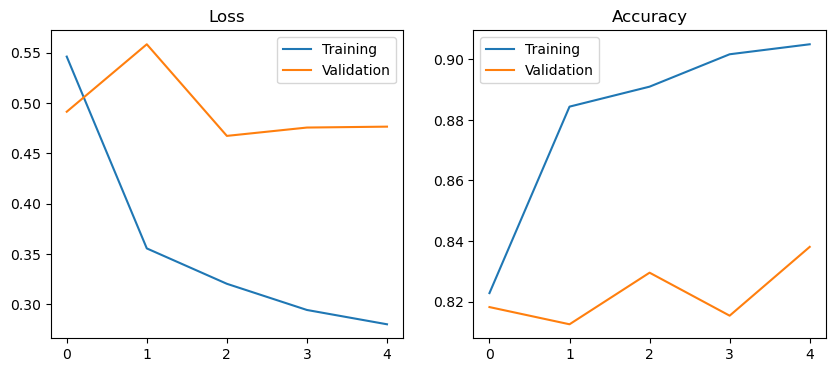

In [11]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy")
    
    plt.legend()
    plt.show()
    
plot_history(effnet_history)

In [12]:
def evaluate_model(model):
    metrics = model.evaluate(test_data)
    print(f"Accuracy: {metrics[1] * 100:.2f}%")

evaluate_model(effnet_model)

16/16 [==============================] - 2s 148ms/step - loss: 0.2862 - accuracy: 0.8880
Accuracy: 88.80%


# Model 1B - EfficientNet with Data Augmentation


In [13]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
], name="augmentation_layers")

In [14]:
model1b_checkpoint_filepath = "model1b/best_model.ckpt"
model1b_checkpoint = tf.keras.callbacks.ModelCheckpoint(model1b_checkpoint_filepath,
                                                        save_best_only=True,
                                                        save_weights_only=False)

In [15]:
tf.random.set_seed(TF_RANDOM_SEED)
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
output_layer = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)


model1b = tf.keras.Model(inputs, output_layer)
model1b.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [16]:
model1b_history = train_model(model1b, [model1b_checkpoint])

Epoch 1/5
313/313 [==============================] - 79s 235ms/step - loss: 0.7256 - accuracy: 0.7429 - val_loss: 0.5829 - val_accuracy: 0.7869
Epoch 2/5
313/313 [==============================] - 71s 227ms/step - loss: 0.5366 - accuracy: 0.8059 - val_loss: 0.5627 - val_accuracy: 0.7983
Epoch 3/5
313/313 [==============================] - 72s 230ms/step - loss: 0.4998 - accuracy: 0.8196 - val_loss: 0.5008 - val_accuracy: 0.8153
Epoch 4/5
313/313 [==============================] - 33s 105ms/step - loss: 0.4776 - accuracy: 0.8285 - val_loss: 0.5342 - val_accuracy: 0.8125
Epoch 5/5
313/313 [==============================] - 32s 103ms/step - loss: 0.4643 - accuracy: 0.8317 - val_loss: 0.5334 - val_accuracy: 0.8295


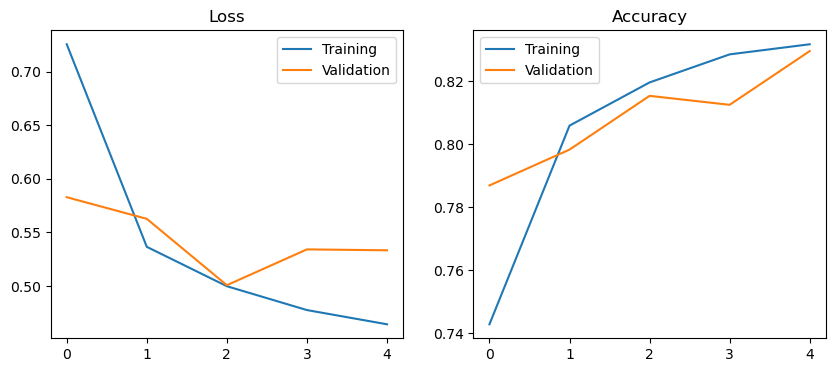

In [17]:
plot_history(model1b_history)

In [18]:
evaluate_model(model1b)

16/16 [==============================] - 2s 103ms/step - loss: 0.3900 - accuracy: 0.8440
Accuracy: 84.40%


# Model 1C - Fine-tuning layers

In [19]:
model1c = tf.keras.models.load_model(model1b_checkpoint_filepath)
model1c.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [20]:
evaluate_model(model1c)

16/16 [==============================] - 3s 86ms/step - loss: 0.3891 - accuracy: 0.8540
Accuracy: 85.40%


In [21]:
for i, layer in enumerate(model1c.layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_3: True
1 augmentation_layers: True
2 efficientnetb0: False
3 global_average_pooling2d_1: True
4 dense_1: True


In [22]:
model1c.layers[2].trainable = True
for i, layer in enumerate(model1c.layers[2].layers):
    layer.trainable = (i >= 227)
    
for i, layer in enumerate(model1c.layers[2].layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_4: False
1 rescaling_1: False
2 normalization_1: False
3 tf.math.truediv_1: False
4 stem_conv_pad: False
5 stem_conv: False
6 stem_bn: False
7 stem_activation: False
8 block1a_dwconv: False
9 block1a_bn: False
10 block1a_activation: False
11 block1a_se_squeeze: False
12 block1a_se_reshape: False
13 block1a_se_reduce: False
14 block1a_se_expand: False
15 block1a_se_excite: False
16 block1a_project_conv: False
17 block1a_project_bn: False
18 block2a_expand_conv: False
19 block2a_expand_bn: False
20 block2a_expand_activation: False
21 block2a_dwconv_pad: False
22 block2a_dwconv: False
23 block2a_bn: False
24 block2a_activation: False
25 block2a_se_squeeze: False
26 block2a_se_reshape: False
27 block2a_se_reduce: False
28 block2a_se_expand: False
29 block2a_se_excite: False
30 block2a_project_conv: False
31 block2a_project_bn: False
32 block2b_expand_conv: False
33 block2b_expand_bn: False
34 block2b_expand_activation: False
35 block2b_dwconv: False
36 block2b_bn: False
37 block2b_

In [23]:
model1c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model1c_history = model1c.fit(train_data,
                            epochs=EPOCHS + 15,
                            batch_size=BATCH_SIZE,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=int(0.25 * len(valid_data)),
                            initial_epoch=5)

Epoch 6/20
313/313 [==============================] - 43s 117ms/step - loss: 0.5016 - accuracy: 0.8170 - val_loss: 0.6483 - val_accuracy: 0.7812
Epoch 7/20
313/313 [==============================] - 34s 110ms/step - loss: 0.4408 - accuracy: 0.8420 - val_loss: 0.5404 - val_accuracy: 0.8040
Epoch 8/20
313/313 [==============================] - 34s 107ms/step - loss: 0.3902 - accuracy: 0.8608 - val_loss: 0.4751 - val_accuracy: 0.8494
Epoch 9/20
313/313 [==============================] - 34s 109ms/step - loss: 0.3745 - accuracy: 0.8660 - val_loss: 0.4422 - val_accuracy: 0.8636
Epoch 10/20
313/313 [==============================] - 33s 104ms/step - loss: 0.3604 - accuracy: 0.8751 - val_loss: 0.4621 - val_accuracy: 0.8523
Epoch 11/20
313/313 [==============================] - 34s 108ms/step - loss: 0.3381 - accuracy: 0.8806 - val_loss: 0.5067 - val_accuracy: 0.8409
Epoch 12/20
313/313 [==============================] - 34s 108ms/step - loss: 0.3203 - accuracy: 0.8892 - val_loss: 0.5443 - val

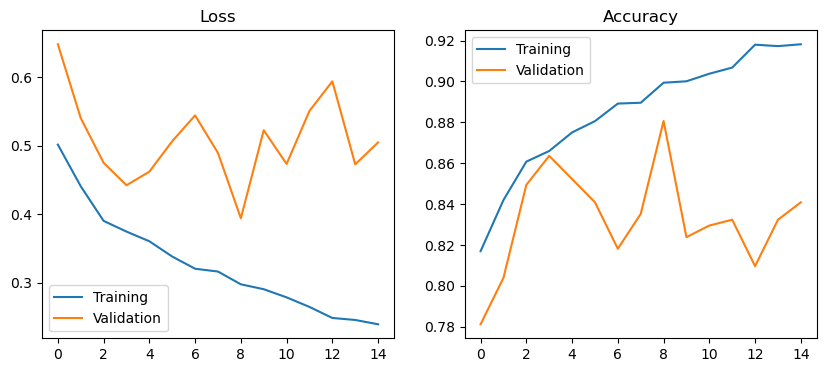

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [24]:
plot_history(model1c_history)
model1c_history.epoch

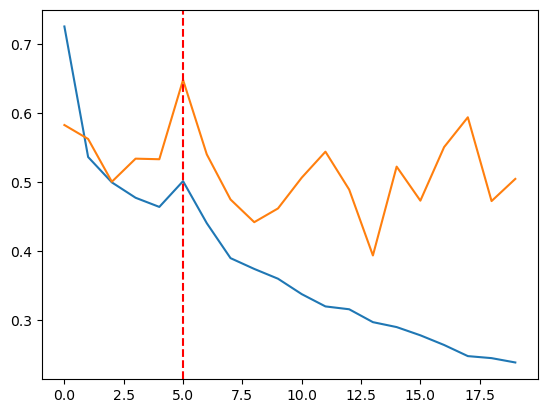

In [25]:
plt.plot(model1b_history.epoch + model1c_history.epoch, 
         model1b_history.history["loss"] + model1c_history.history["loss"])
plt.plot(model1b_history.epoch + model1c_history.epoch, 
         model1b_history.history["val_loss"] + model1c_history.history["val_loss"])
plt.axvline(5, 0, 1, color="red", linestyle="--")
plt.show()

In [26]:
model1b_history.history["loss"]

[0.725579023361206,
 0.5365798473358154,
 0.4998455047607422,
 0.47758206725120544,
 0.46432510018348694]

In [27]:
model1c_history.history["loss"]

[0.5016226768493652,
 0.4407746493816376,
 0.3901713490486145,
 0.3745385408401489,
 0.36037737131118774,
 0.33806437253952026,
 0.3202570378780365,
 0.316137433052063,
 0.29748377203941345,
 0.29034560918807983,
 0.2784263491630554,
 0.2644256055355072,
 0.24831515550613403,
 0.2453853338956833,
 0.2390940934419632]

In [28]:
evaluate_model(model1c)

16/16 [==============================] - 1s 88ms/step - loss: 0.2555 - accuracy: 0.8920
Accuracy: 89.20%
